In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score

import numpy as np
import pandas as pd
from sklearn.dummy import DummyRegressor
def MeanBaseline2(df:pd.DataFrame,df_t:pd.DataFrame=None):
    base_m = DummyRegressor(strategy='mean')
    base_x = df[['Solar Zenith Angle']]
    base_y = df[['solar']].copy()
    base_m.fit(base_x,base_y)
    if df_t is not None:
        base_x_t = df_t[['Solar Zenith Angle']]
        base_y_t = df_t[['solar']].copy()
        base_y_t['Prediction'] = base_m.predict(base_x_t)
        return base_y_t
    else:
        base_y['Prediction'] = base_m.predict(base_x)
        return base_y

def PreviousYearsBaseline2(df:pd.DataFrame,df_t:pd.DataFrame):
    df_p = df_t[['solar']].copy()
    df_pred = df.groupby([df.index.month,df.index.day,df.index.hour]).agg('mean')['solar']
    df_pred.index = pd.to_datetime(['2024-{0:02d}-{1:02d} {2:02d}:00:00+00:00'.format(m,d,h) for m,d,h in df_pred.index])
    df_p['Prediction'] = df_pred
    return df_p.dropna()

def plot_data2(title:str,df:pd.DataFrame,day=None):
    if day is not None:#Optional day argument starts are chosen day
        start = pd.Timestamp(year=df.index.year[1],month=1,day=1).tz_localize('UTC')+pd.Timedelta(days=day-1)
        end = start+pd.Timedelta(days=14)
    else:#Otherwise randomly choose a day to begin plot
        days = [day for day in df.index.unique() if day.day_of_year < 350]
        start = np.random.choice(days)
        end = start+pd.Timedelta(days=14)

    plot_df = df.asfreq('h')#Add NaN rows so pyplot skips interpolation across jumps
    plot_df = plot_df.loc[start:end]

    #Metrics added to plot labeling
    rmse = root_mean_squared_error(df['solar'],df['Prediction'])
    r2 = r2_score(df['solar'],df['Prediction'])

    plt.figure(figsize=(20, 5))
    plt.plot(plot_df.index, plot_df['solar'], label='Actual solar', alpha=0.5)
    plt.plot(plot_df.index, plot_df['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
    plt.title(f"Actual vs Predicted Solar Energy in CO over Time ({title})")
    plt.xlabel("Time")
    plt.ylabel("Solar Energy CO")
    plt.text(0.94,1.05,f'RMSE: {rmse:.2f}\n r2: {r2:.4f}',transform=plt.gca().transAxes,bbox=dict(boxstyle="square", facecolor="white"))
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

def plot_daily_data2(title:str,df:pd.DataFrame):
    #Convert dataframe of hourly data to daily data of total energy
    df_daily = df.resample('d').agg('sum')

    #Metrics added to plot labeling
    rmse = root_mean_squared_error(df_daily['solar'],df_daily['Prediction'])
    r2 = r2_score(df_daily['solar'],df_daily['Prediction'])

    plt.figure(figsize=(20, 5))
    sns.scatterplot(df_daily, x=df_daily.index,y='solar',label='Actual Energy')
    sns.scatterplot(df_daily, x=df_daily.index,y='Prediction',label='Predicted Energy')
    plt.title(f"Actual vs Predicted Energy Over Time Daily Total ({title})")
    plt.xlabel("Time")
    plt.ylabel("solar")
    plt.text(0.94,1.05,f'RMSE: {rmse:.2f}\n r2: {r2:.4f}',transform=plt.gca().transAxes,bbox=dict(boxstyle="square", facecolor="white"))
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()  

In [18]:
SolarData22 = pd.read_csv('../data/Processed/Solar2022.csv',index_col=0,parse_dates=[0])
SolarData23 = pd.read_csv('../data/Processed/Solar2023.csv',index_col=0,parse_dates=[0])
SolarData24 = pd.read_csv('../data/Processed/Solar2024.csv',index_col=0,parse_dates=[0])

co22 = pd.read_csv('../data/Processed/co22.csv',index_col=0,parse_dates=[0])
co23 = pd.read_csv('../data/Processed/co23.csv',index_col=0,parse_dates=[0])
co24 = pd.read_csv('../data/Processed/co24.csv',index_col=0,parse_dates=[0])

coordinates = pd.read_csv('../data/Processed/solarplantscoordinates.csv')

combined_2022 = SolarData22.join(co22, how='inner')
combined_2023 = SolarData23.join(co23, how='inner')
combined_2024 = SolarData24.join(co24, how='inner')

SolarDataDay22 = SolarData22[SolarData22['Solar Zenith Angle']<np.pi/2]
SolarDataDay23 = SolarData23[SolarData23['Solar Zenith Angle']<np.pi/2]
SolarDataDay24 = SolarData24[SolarData24['Solar Zenith Angle']<np.pi/2]

comDay22 = combined_2022[combined_2022['Solar Zenith Angle']<np.pi/2]
comDay23 = combined_2023[combined_2023['Solar Zenith Angle']<np.pi/2]
comDay24 = combined_2024[combined_2024['Solar Zenith Angle']<np.pi/2]

We are considering now the solar energy of all the state no just the solar energy of the plant.

,p_name,p_year,p_cap_ac,ylat,xlong
0,Neptune Energy Center Hybrid,2020,325.0,38.32446,-104.40404
1,Thunder Wolf Energy Center Hybrid,2022,248.0,38.17302,-104.38211
2,Bighorn Solar 1,2021,240.0,38.19255,-104.59910
3,Sun Mountain Solar 1,2021,200.0,38.17013,-104.52280
4,Pike Solar Hybrid,2023,175.0,38.67267,-104.61202


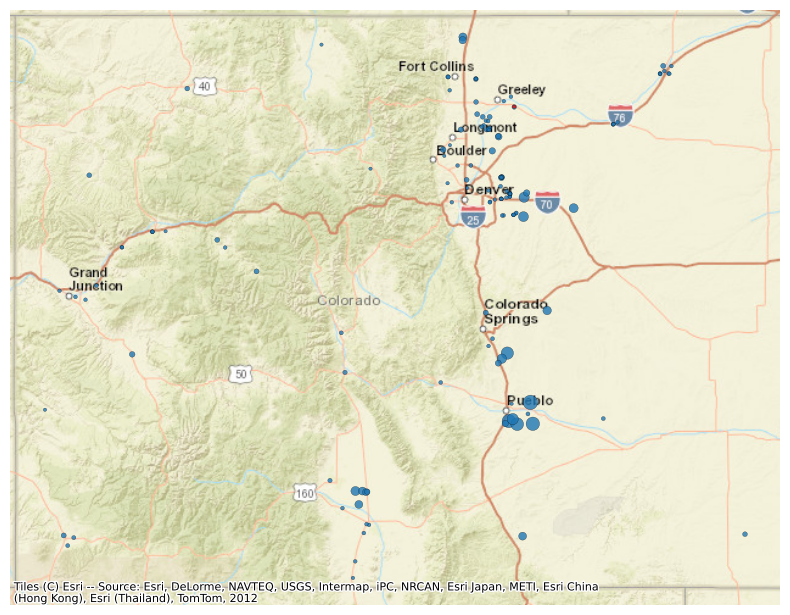

In [57]:
import geopandas as gpd, contextily as cx, matplotlib.pyplot as plt
import numpy as np

# Create a color column - default orange, special location blue
coordinates['color'] = 'tab:blue'
special_mask = (coordinates['ylat'] == 40.38766) & (coordinates['xlong'] == -104.55098)
coordinates.loc[special_mask, 'color'] = 'red'

gdf = gpd.GeoDataFrame(
    coordinates.copy(),
    geometry=gpd.points_from_xy(coordinates["xlong"].astype(float), coordinates["ylat"].astype(float)),
    crs="EPSG:4326"
).to_crs(3857)

ax = gdf.plot(
    figsize=(8,8),
    markersize=gdf.get("p_cap_ac", 0).fillna(0).astype(float).pow(0.5)*6,
    alpha=0.8, color=gdf['color'], edgecolor="k", linewidth=0.2
)
cx.add_basemap(ax, source=cx.providers.Esri.WorldStreetMap, crs=gdf.crs)
ax.set_axis_off(); plt.tight_layout(); plt.show()

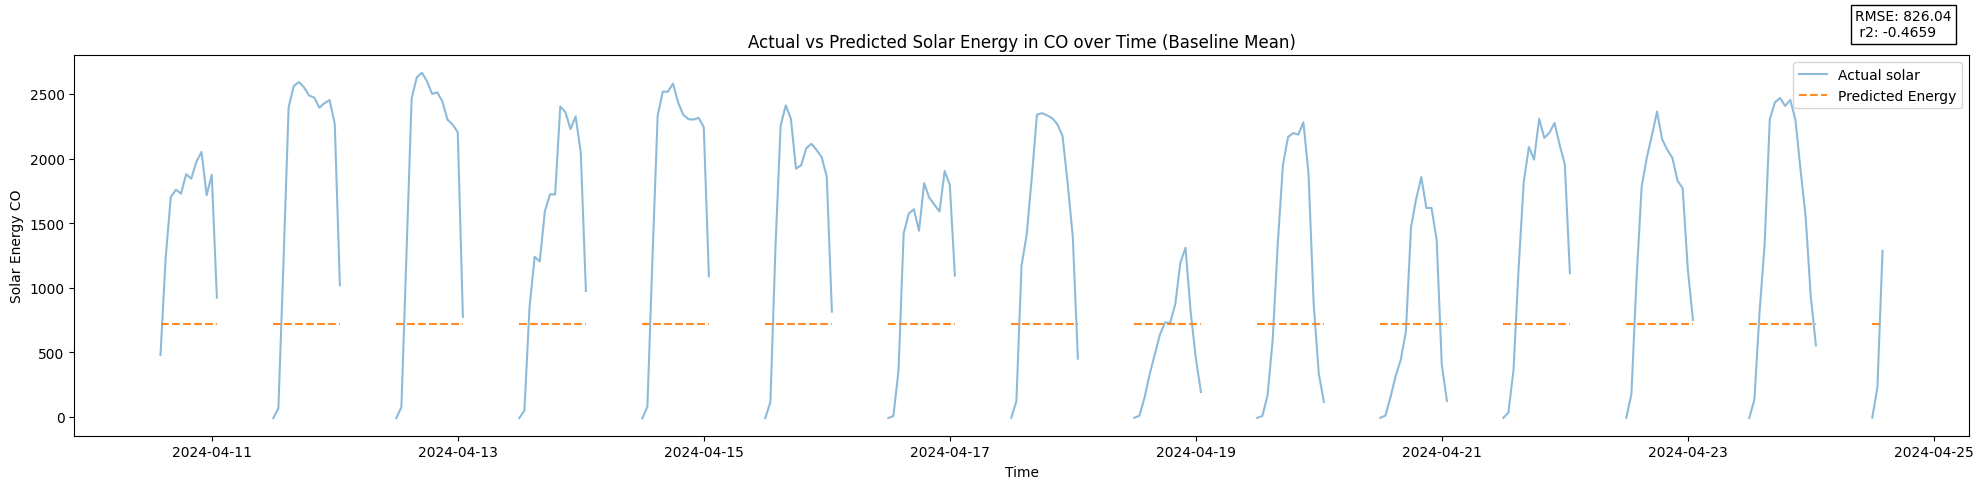

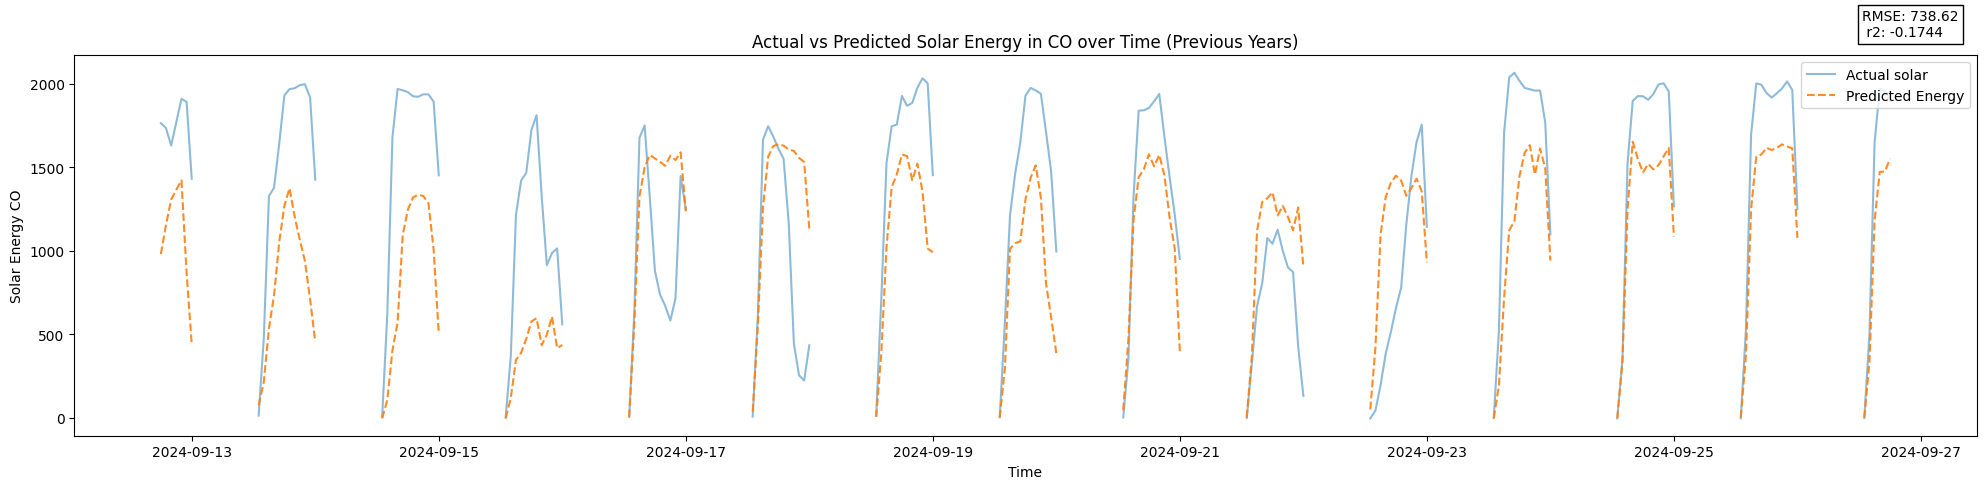

In [58]:
SolarTrainA = pd.concat([comDay22, comDay23])
SolarTestA = comDay24.copy()
plot_data2('Baseline Mean',MeanBaseline2(SolarTrainA,SolarTestA))
plot_data2('Previous Years',PreviousYearsBaseline2(SolarTrainA,SolarTestA))

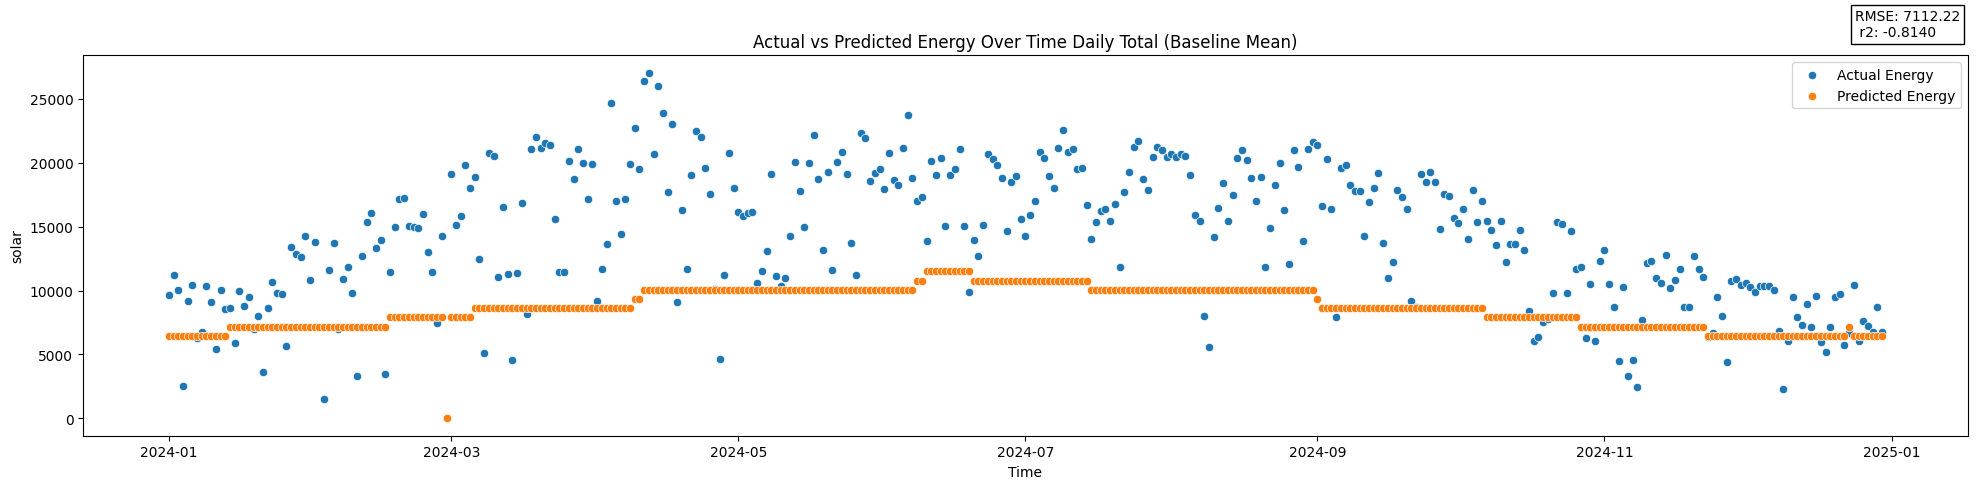

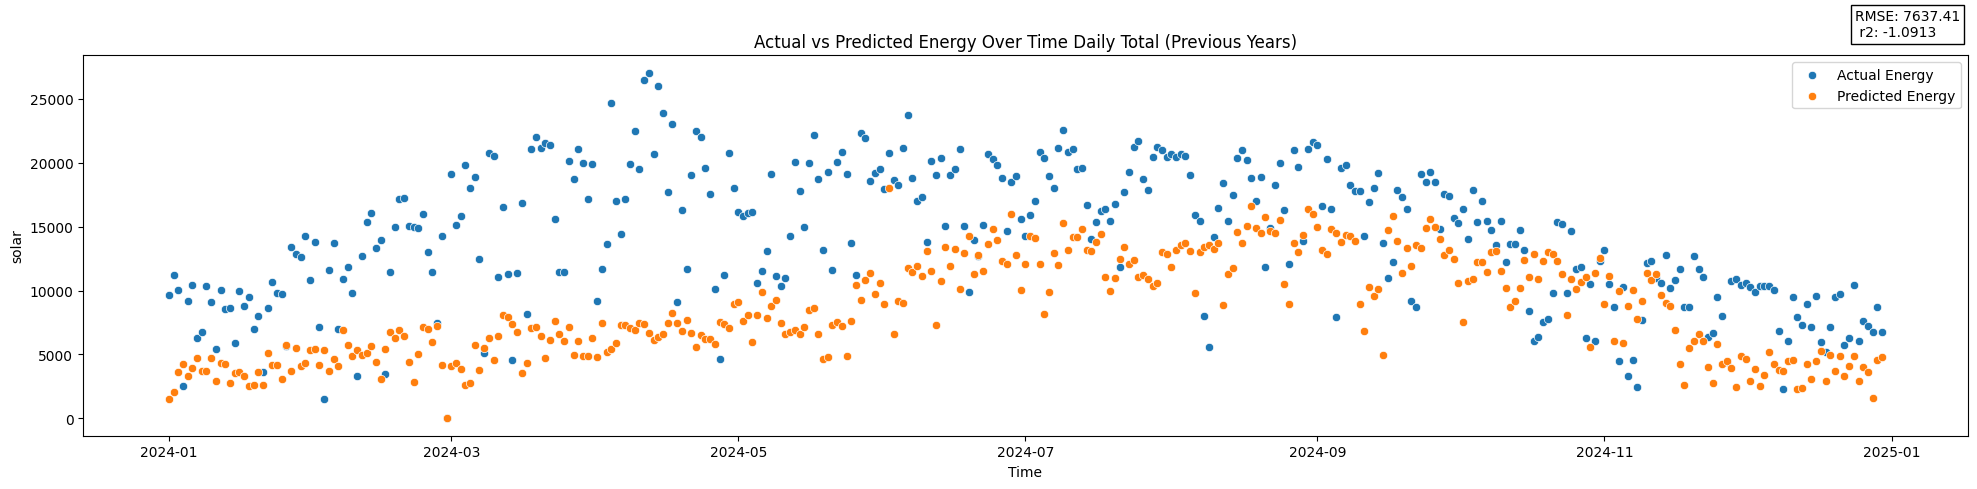

In [7]:
plot_daily_data2('Baseline Mean',MeanBaseline2(SolarTrainA,SolarTestA))
plot_daily_data2('Previous Years',PreviousYearsBaseline2(SolarTrainA,SolarTestA))

The problem seems to be the increase of solar energy capacity in Colorado

In [39]:
coordinates[['p_name', 'p_year', 'p_cap_ac', 'ylat', 'xlong']].head(4)

,p_name,p_year,p_cap_ac,ylat,xlong
0,Neptune Energy Center Hybrid,2020,325.0,38.32446,-104.40404
1,Thunder Wolf Energy Center Hybrid,2022,248.0,38.17302,-104.38211
2,Bighorn Solar 1,2021,240.0,38.19255,-104.59910
3,Sun Mountain Solar 1,2021,200.0,38.17013,-104.52280


In [31]:
# Capacity up to and including 2022
capacity_2022 = coordinates[coordinates['p_year'] <= 2022]['p_cap_ac'].sum()

# Capacity up to and including 2023  
capacity_2023 = coordinates[coordinates['p_year'] <= 2023]['p_cap_ac'].sum()

# Capacity up to and including 2024
capacity_2024 = coordinates[coordinates['p_year'] <= 2024]['p_cap_ac'].sum()

print(f"Capacity through 2022: {capacity_2022:.1f} MW")
print(f"Capacity through 2023: {capacity_2023:.1f} MW") 
print(f"Capacity through 2024: {capacity_2024:.1f} MW")

Capacity through 2022: 1871.5 MW
Capacity through 2023: 2167.5 MW
Capacity through 2024: 2170.9 MW


In [66]:
filtered_df = coordinates[
    coordinates['p_name'].astype(str).str.startswith('SR Kersey II') ]
filtered_df[['p_name',  'p_year',  'p_cap_ac', 'ylat', 'xlong']].head()

,p_name,p_year,p_cap_ac,ylat,xlong
141,SR Kersey II,2019,1.0,40.38766,-104.55098
